In [1]:
##

import os
from os.path import abspath
import numpy as np
import nibabel as nib
from nipype import Workflow, Node, MapNode, Function
from nipype.interfaces import fsl
from nipype.interfaces.dcm2nii import Dcm2niix
from nipype.testing import example_data
import applyxfm4d 
from nilearn import plotting
from nilearn.image import smooth_img, resample_img,mean_img
from nilearn.plotting import plot_anat
from nilearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

test_dir = '/home/harryzhang/Desktop/test_registration/'

ModuleNotFoundError: No module named 'applyxfm4d'

In [ ]:
## generate Nifty file from Dicom

# t2 nifty generation
converter = Dcm2niix()
converter.inputs.source_dir = test_dir+'dicom/ep2d_diff_3scan_trace*ep_b0'
converter.inputs.compression = 5
converter.inputs.out_filename = 't2_from_dicom'
converter.inputs.output_dir = test_dir
converter.run()

In [68]:
# dwi nifty generation
converter = Dcm2niix()
converter.inputs.source_dir = test_dir+'dicom/ep2d_diff_3scan_trace*ep_b1000t'
converter.inputs.compression = 5
converter.inputs.out_filename = 'dwi'
converter.inputs.output_dir = test_dir
converter.run()

190529-13:17:35,135 nipype.interface INFO:
	 stdout 2019-05-29T13:17:35.135292:Chris Rorden's dcm2niiX version v1.0.20171215 (OpenJPEG build) GCC7.3.0 (64-bit Linux)
190529-13:17:35,136 nipype.interface INFO:
	 stdout 2019-05-29T13:17:35.135292:Found 26 DICOM image(s)
190529-13:17:35,137 nipype.interface INFO:
	 stdout 2019-05-29T13:17:35.135292:Convert 26 DICOM as /home/harryzhang/Desktop/test_registration/dwia (130x130x26x1)
190529-13:17:35,167 nipype.interface INFO:
	 stdout 2019-05-29T13:17:35.167813:compress: "/usr/bin/pigz" -n -f -5 "/home/harryzhang/Desktop/test_registration/dwia.nii"
190529-13:17:35,168 nipype.interface INFO:
	 stdout 2019-05-29T13:17:35.167813:Conversion required 0.039927 seconds (0.004125 for core code).


In [4]:
# perfusion nifty generation
converter = Dcm2niix()
converter.inputs.source_dir = test_dir+'dicom/ep2d_perf'
converter.inputs.compression = 5
converter.inputs.out_filename = 'pwi_from_dicom'
converter.inputs.output_dir = test_dir
converter.run()

190528-16:02:24,238 nipype.interface INFO:
	 stdout 2019-05-28T16:02:24.238228:Chris Rorden's dcm2niiX version v1.0.20171215 (OpenJPEG build) GCC7.3.0 (64-bit Linux)
190528-16:02:24,239 nipype.interface INFO:
	 stdout 2019-05-28T16:02:24.238228:Found 1200 DICOM image(s)
190528-16:02:24,239 nipype.interface INFO:
	 stdout 2019-05-28T16:02:24.238228:slices stacked despite varying acquisition numbers (if this is not desired please recompile)
190528-16:02:24,240 nipype.interface INFO:
	 stdout 2019-05-28T16:02:24.238228:Convert 1200 DICOM as /home/harryzhang/Desktop/test_registration/pwi_from_dicom (128x128x24x50)
190528-16:02:24,647 nipype.interface INFO:
	 stdout 2019-05-28T16:02:24.647286:compress: "/usr/bin/pigz" -n -f -5 "/home/harryzhang/Desktop/test_registration/pwi_from_dicom.nii"
190528-16:02:24,647 nipype.interface INFO:
	 stdout 2019-05-28T16:02:24.647286:Conversion required 0.499677 seconds (0.155478 for core code).


In [15]:
# use BET to do skull stripping
# explore more options later

btr = fsl.BET()
btr.inputs.in_file = test_dir+'t2_from_dicom.nii.gz'
btr.inputs.frac = 0.2
btr.inputs.vertical_gradient = 0.7
btr.inputs.out_file = test_dir+'t2_stripped.nii.gz'
res = btr.run() 

In [148]:
# register t2 to atlas using mutual information

flt = fsl.FLIRT(bins=640, cost_func='mutualinfo',interp='spline',
                searchr_x=[-180,180],searchr_y=[-180,180],searchr_z=[-180,180],dof=6)
flt.inputs.in_file = test_dir+'t2_from_dicom.nii.gz'
flt.inputs.reference = test_dir+'baseanat.nii.gz'
flt.inputs.out_file = test_dir+'r_t2.nii.gz'
flt.inputs.out_matrix_file = test_dir+'r_transform.mat'
res = flt.run() 


In [149]:
# register with dwi

applyxfm = fsl.preprocess.ApplyXFM()
applyxfm.inputs.in_file = test_dir+'dwia.nii.gz'
applyxfm.inputs.in_matrix_file = test_dir+'r_transform.mat'
applyxfm.inputs.out_file =  test_dir+'r_dwi.nii.gz'
applyxfm.inputs.reference = test_dir+'r_t2.nii.gz'
applyxfm.inputs.apply_xfm = True
result = applyxfm.run() 


In [162]:
# register with perfusion
import os

os.chdir('/home/harryzhang/Desktop/test_registration')

!applyxfm4D pwi_from_dicom.nii.gz r_dwi.nii.gz r_pwi.nii.gz r_transform.mat -singlematrix


# applyxfm4d = applyxfm4d.ApplyXfm4D()
# applyxfm4d.inputs.in_file = test_dir+'pwi.nii.gz'
# applyxfm4d.inputs.single_matrix = test_dir+'r_transform.mat'
# applyxfm4d.inputs.ref_vol = test_dir+'r_dwi.nii.gz'
# applyxfm4d.inputs.out_file = test_dir+'r_pwi.nii.gz'
# res = applyxfm4d.run() 

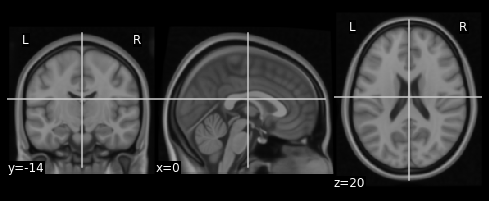

In [18]:
plotting.plot_anat(test_dir+'baseanat.nii.gz')

/home/harryzhang/PycharmProjects/gcn_metric_learning/venv/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


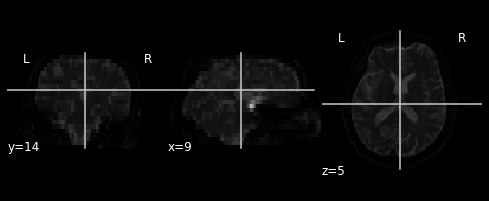

In [17]:
plotting.plot_anat(test_dir+'t2_from_dicom.nii.gz')

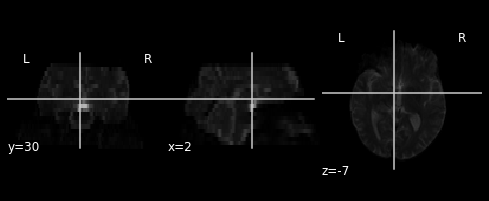

In [16]:
plotting.plot_anat(test_dir+'t2_stripped.nii.gz')

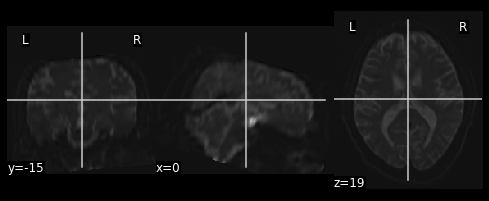

In [150]:
plotting.plot_anat(test_dir+'r_t2.nii.gz')

/home/harryzhang/PycharmProjects/gcn_metric_learning/venv/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


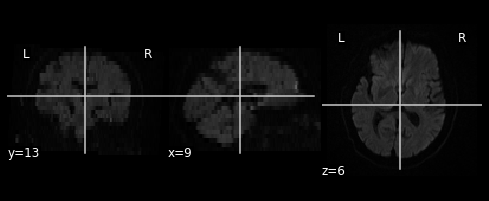

In [91]:
plotting.plot_anat(test_dir+'dwia.nii.gz')

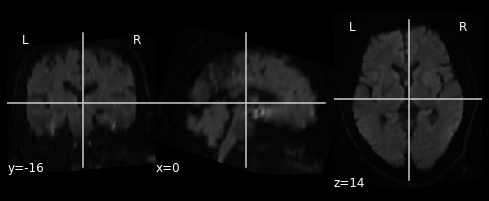

In [151]:
plotting.plot_anat(test_dir+'r_dwi.nii.gz')

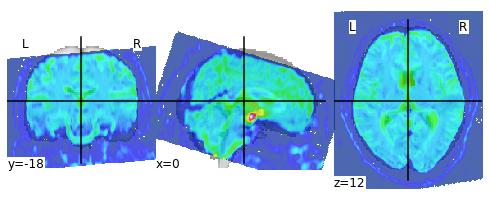

In [152]:
plotting.plot_roi(test_dir+'r_t2.nii.gz')

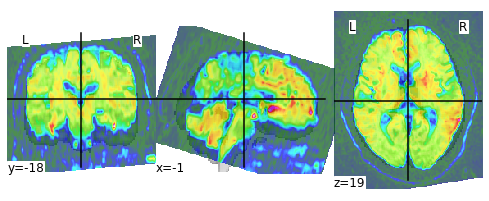

In [153]:
plotting.plot_roi(test_dir+'r_dwi.nii.gz')

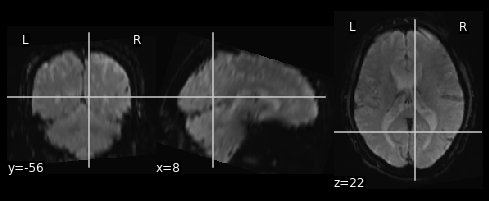

In [19]:
mean_pwi = mean_img(test_dir+'r_pwi.nii.gz')

plotting.plot_anat(mean_pwi)

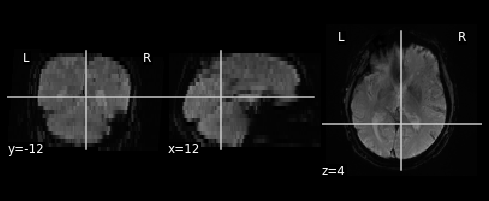

In [21]:
mean_pwi = mean_img(test_dir+'pwi_from_dicom.nii.gz')

plotting.plot_anat(mean_pwi)

In [ ]:
pwi = nib.load(test_dir+'pwi.nii.gz')
pwi.shape

In [ ]:
r_t2 = nib.load(test_dir+'r_t2.nii.gz')
r_t2.shape

In [ ]:
atlas = nib.load(test_dir+'ICBM_T2Atlas.hdr')
atlas_ds = resample_img(atlas,target_affine=atlas.affine,target_shape=dwi.shape,interpolation='nearest')

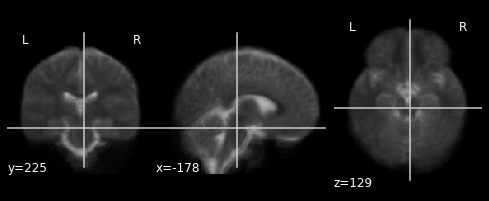

In [35]:
plotting.plot_anat(test_dir+'ICBM_T2Atlas.hdr')

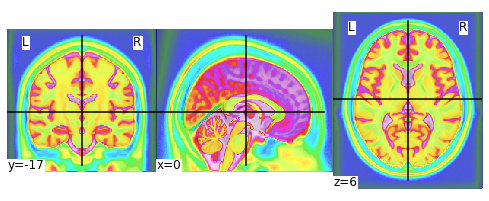

In [132]:
plotting.plot_roi(test_dir+'/mni_icbm152_nlin_sym_09a/mni_icbm152_t2_tal_nlin_sym_09a.nii')

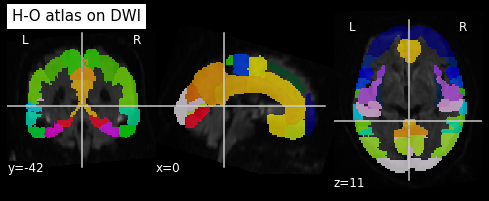

In [11]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
ho_maps = dataset.maps
plotting.plot_roi(ho_maps, test_dir+'r_dwi.nii.gz',title="H-O atlas on DWI")

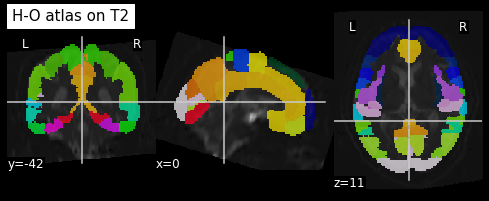

In [12]:
plotting.plot_roi(ho_maps, test_dir+'r_t2.nii.gz',title="H-O atlas on T2")

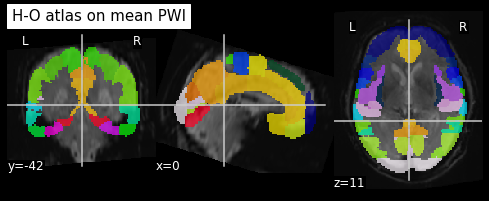

In [13]:
plotting.plot_roi(ho_maps, mean_pwi,title="H-O atlas on mean PWI")